In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
from datasets import load_dataset 
import transformers
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests

In [5]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_train.dataframeName = 'radiologytestdata.csv'
nRow, nCol = df_train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 65450 rows and 3 columns


In [6]:
df_train.head()

,id,name,caption
0,ROCO_00002,PMC4083729_AMHSR-4-14-g002.jpg,Computed tomography scan in axial view showin...
1,ROCO_00003,PMC2837471_IJD2009-150251.001.jpg,Bacterial contamination occurred after comple...
2,ROCO_00004,PMC2505281_11999_2007_30_Fig6_HTML.jpg,The patient had residual paralysis of the han...
3,ROCO_00005,PMC3745845_IJD2013-683423.005.jpg,Panoramic radiograph after immediate loading.\n
4,ROCO_00007,PMC4917066_amjcaserep-17-301-g001.jpg,Plain abdomen x-ray: Multiple air levels at t...


In [7]:
df_train.isnull().sum() 
df_train.dropna(inplace=True)  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='caption_length', ylabel='Count'>

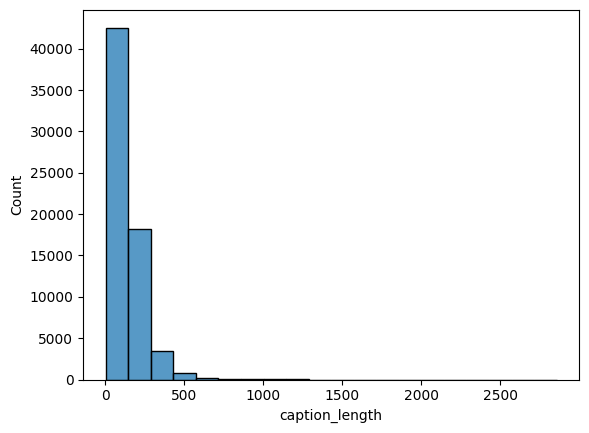

In [8]:
df_train['caption_length'] = df_train['caption'].apply(len)  # Compute caption lengths
sns.histplot(df_train['caption_length'], bins=20)  # Plot histogram of caption lengths


In [9]:
# Download necessary NLTK data
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [15]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    # Lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    return text

In [17]:
# Apply preprocessing to the 'caption' column
df_train['caption_text'] = df_train['caption'].apply(preprocess_text)

In [19]:
# Search those captiones which contains "chest x-ray" words
mask = df_train['caption_text'].str.contains('chest xray', case=False)
filtered_df = df_train[mask]
filtered_df.head()

,id,name,caption,caption_length,caption_text
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",129,chest xray confirm posit guidewir extend right...
90,ROCO_00110,PMC4929806_CCR3-4-682-g003.jpg,Neonatal chest X‐ray of the larger fetus.\n,43,neonat chest xray larger fetu
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,206,chest xray find chest radiograph reveal engorg...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",56,chest xray pa show posit gun nail
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,47,chest xray show rightsid pneumothorax


In [20]:
# Create "images" column to create full path for images
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']
filtered_df.head()

/tmp/ipykernel_34/1067852196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + filtered_df['name']


,id,name,caption,caption_length,caption_text,images
69,ROCO_00087,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",129,chest xray confirm posit guidewir extend right...,/kaggle/input/roco-dataset/all_data/train/radi...
90,ROCO_00110,PMC4929806_CCR3-4-682-g003.jpg,Neonatal chest X‐ray of the larger fetus.\n,43,neonat chest xray larger fetu,/kaggle/input/roco-dataset/all_data/train/radi...
141,ROCO_00172,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,206,chest xray find chest radiograph reveal engorg...,/kaggle/input/roco-dataset/all_data/train/radi...
180,ROCO_00232,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",56,chest xray pa show posit gun nail,/kaggle/input/roco-dataset/all_data/train/radi...
215,ROCO_00274,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,47,chest xray show rightsid pneumothorax,/kaggle/input/roco-dataset/all_data/train/radi...


In [22]:
# Create new directory for training images
folder_path = "/kaggle/working/train"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)


In [23]:
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

In [24]:
# Delete extra column from the dataframe
filtered_df = filtered_df.drop(columns=["images", "id"])

In [58]:
filtered_df.head()

,name,caption,caption_length,caption_text
69,PMC5144533_IJCCM-20-677-g002.jpg,"Chest X-ray, which confirmed the position of ...",129,chest xray confirm posit guidewir extend right...
90,PMC4929806_CCR3-4-682-g003.jpg,Neonatal chest X‐ray of the larger fetus.\n,43,neonat chest xray larger fetu
141,PMC4863054_ir-14-187-g002.jpg,Chest X-ray findings. Chest radiograph reveal...,206,chest xray find chest radiograph reveal engorg...
180,PMC4093973_IJCIIS-4-186-g001.jpg,"Chest X-ray, PA, showing the position of the ...",56,chest xray pa show posit gun nail
215,PMC5616218_cureus-0009-00000001523-i01.jpg,Chest x-ray showing right-sided pneumothorax.\n,47,chest xray show rightsid pneumothorax


In [25]:
# Convert dataframe to json format
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption_text"]}, axis=1).tolist()

In [26]:
# Save data to json file
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))

In [27]:
dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
dataset

Resolving data files:   0%|          | 0/1781 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 1780
})

girl chest xray film done admiss hospit show increas bilater infiltr lung done admiss


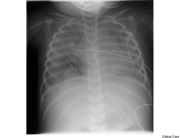

In [28]:
# Visualize the first images and its caption from training data
example = dataset[0]
image = example["image"]
width, height = image.size
print(example["text"])
display(image.resize((int(0.3*width), int(0.3*height))))

In [78]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [79]:
processor = AutoProcessor.from_pretrained("microsoft/git-large-textcaps")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-textcaps")

In [80]:
train_dataset = ImageCaptioningDataset(dataset, processor)

In [81]:
train_dataset

In [82]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [84]:
train_dataloader

In [85]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [86]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0650, grad_fn=<NllLossBackward0>)

In [53]:
!pip install efficientnet_pytorch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=386479092bb508e974ad1376ec343a99284597fb2de301fa694dab3b8221c9d6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [93]:
from tqdm import tqdm  # Import tqdm for progress bar

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
    print("Epoch:", epoch)
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False)
    for idx, batch in enumerate(progress_bar):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())  # Update progress bar

    print("Loss:", loss.item())


Epoch: 0


Epoch 0:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 1/890 [00:00<06:26,  2.30it/s, loss=0.115]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 2/890 [00:00<06:20,  2.33it/s, loss=0.155]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 3/890 [00:01<06:15,  2.36it/s, loss=0.251]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   0%|          | 4/890 [00:01<06:14,  2.37it/s, loss=0.17] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   1%|          | 5/890 [00:02<06:15,  2.36it/s, loss=0.116]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 0:   1%|          | 6/890 [00:02<06:13,  2.37it/s, loss=0.0245]Unused or unrecognized kwargs: padding.
Unused or unrecognized 

Loss: 0.06882432103157043
Epoch: 1


Epoch 1:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 1/890 [00:00<06:20,  2.33it/s, loss=0.0632]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 2/890 [00:00<06:13,  2.38it/s, loss=0.0735]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 3/890 [00:01<06:10,  2.40it/s, loss=0.226] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   0%|          | 4/890 [00:01<06:10,  2.39it/s, loss=0.146]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   1%|          | 5/890 [00:02<06:10,  2.39it/s, loss=0.13] Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 1:   1%|          | 6/890 [00:02<06:11,  2.38it/s, loss=0.0702]Unused or unrecognized kwargs: padding.
Unused or unrecogniz

Loss: 0.12095533311367035
Epoch: 2


Epoch 2:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 1/890 [00:00<06:07,  2.42it/s, loss=0.0563]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 2/890 [00:00<06:04,  2.44it/s, loss=0.09]  Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 3/890 [00:01<06:07,  2.41it/s, loss=0.125]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   0%|          | 4/890 [00:01<06:10,  2.39it/s, loss=0.0432]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   1%|          | 5/890 [00:02<06:07,  2.41it/s, loss=0.0633]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 2:   1%|          | 6/890 [00:02<06:07,  2.41it/s, loss=0.145] Unused or unrecognized kwargs: padding.
Unused or unrecogni

Loss: 0.10074197500944138
Epoch: 3


Epoch 3:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 1/890 [00:00<06:09,  2.40it/s, loss=0.0346]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 2/890 [00:00<06:09,  2.40it/s, loss=0.0853]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 3/890 [00:01<06:08,  2.41it/s, loss=0.0729]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   0%|          | 4/890 [00:01<06:10,  2.39it/s, loss=0.0425]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   1%|          | 5/890 [00:02<06:09,  2.40it/s, loss=0.0447]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 3:   1%|          | 6/890 [00:02<06:08,  2.40it/s, loss=0.0713]Unused or unrecognized kwargs: padding.
Unused or unrecogn

Loss: 0.09338659048080444
Epoch: 4


Epoch 4:   0%|          | 0/890 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 1/890 [00:00<06:16,  2.36it/s, loss=0.12]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 2/890 [00:00<06:12,  2.38it/s, loss=0.0556]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 3/890 [00:01<06:11,  2.39it/s, loss=0.0896]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   0%|          | 4/890 [00:01<06:09,  2.39it/s, loss=0.0379]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   1%|          | 5/890 [00:02<06:08,  2.40it/s, loss=0.0307]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Epoch 4:   1%|          | 6/890 [00:02<06:10,  2.39it/s, loss=0.0379]Unused or unrecognized kwargs: padding.
Unused or unrecogniz

Loss: 0.0970044881105423


In [94]:
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)


[]

In [95]:
load_model = AutoModelForCausalLM.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

In [96]:
# Creating Test Dataset

df_test = pd.read_csv('/kaggle/input/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
mask = df_test['caption'].str.contains('chest x-ray', case=False)
filtered_df = df_test[mask]
filtered_df.head()
filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']
filtered_df.head()
folder_path = "/kaggle/working/test"
if not os.path.exists(folder_path):
    os.mkdir(folder_path)
# Iterate through the DataFrame and move the files to the destination folder
for index, row in filtered_df.iterrows():
    source_file = row["images"]
    file_name = os.path.basename(source_file)
    destination_file = os.path.join(folder_path, file_name)
    
    # Use shutil.move() to move the file
    shutil.copy(source_file, folder_path)

filtered_df = filtered_df.drop(columns=["images", "id"])
captions = filtered_df.apply(lambda row: {"file_name": row["name"], "text": row["caption"]}, axis=1).tolist()
# add metadata.jsonl file to this folder
with open(folder_path + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item))
test_dataset = load_dataset("imagefolder", data_dir=folder_path, split="train")
test_dataset

/tmp/ipykernel_34/3653442878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + filtered_df['name']


Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 199
})

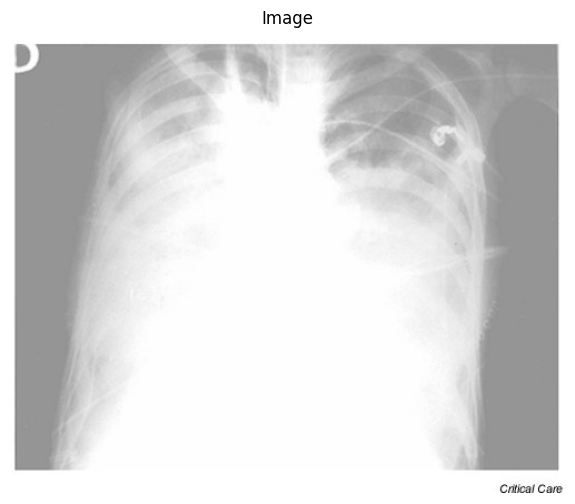

Generated Caption: chest xray show larg mass opac left hemithorax


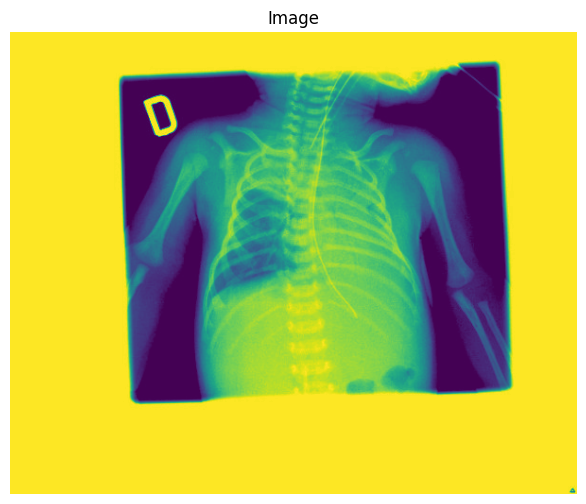

Generated Caption: chest xray show bilater diffus infiltr


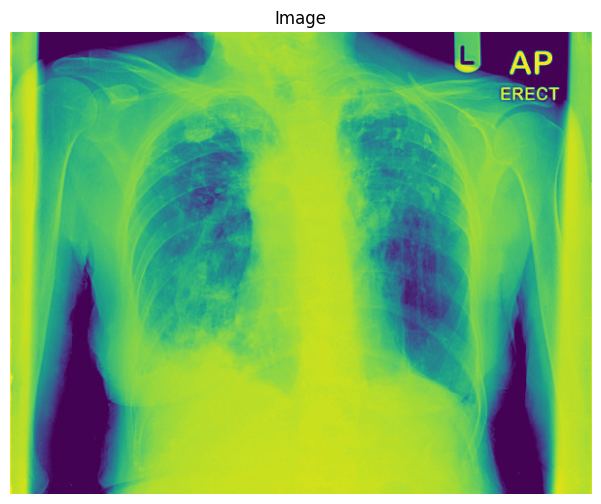

Generated Caption: chest xray show larg opac left hemithorax


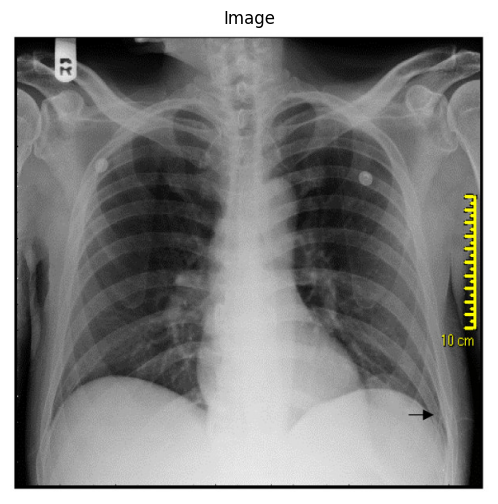

Generated Caption: chest xray show bilater diffus infiltr


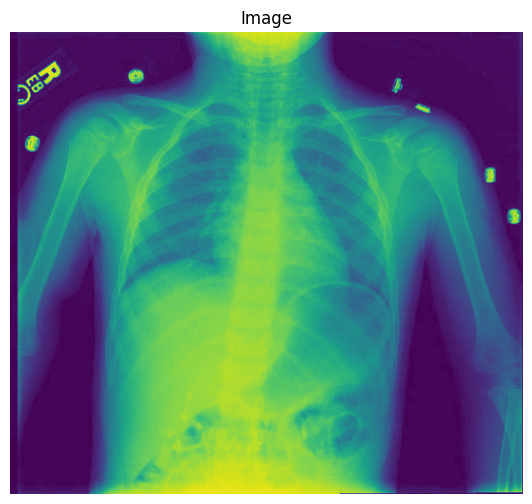

Generated Caption: chest xray show bilater diffus infiltr


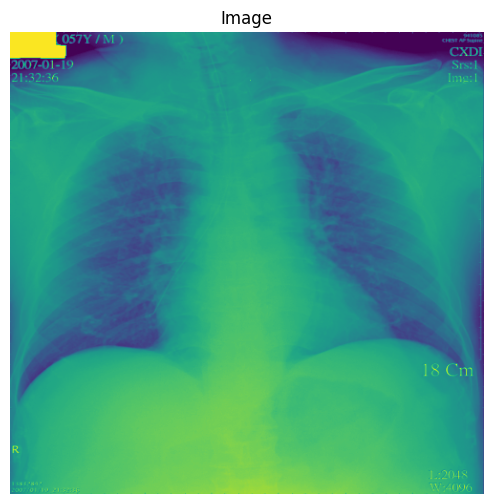

Generated Caption: chest xray show larg mass caviti mass mediastinum left hemithorax


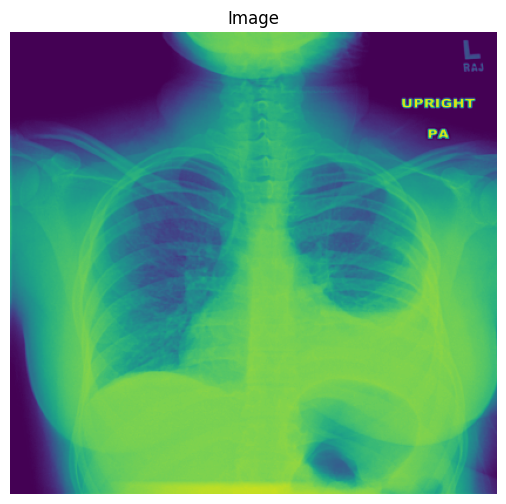

Generated Caption: chest xray show larg opac right hemithorax


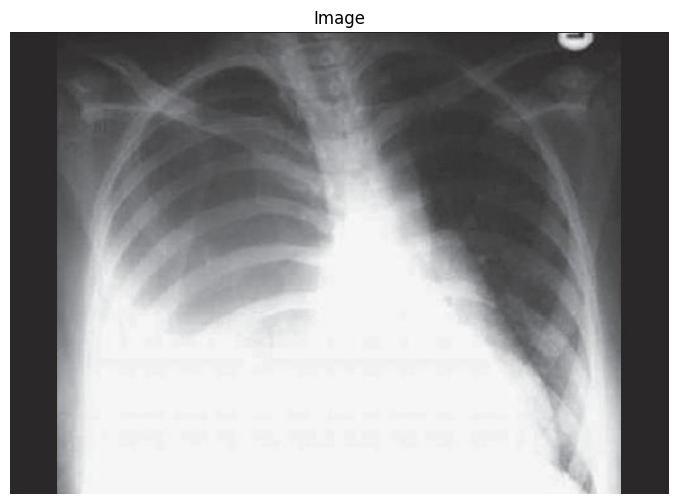

Generated Caption: chest xray show bilater diffus infiltr


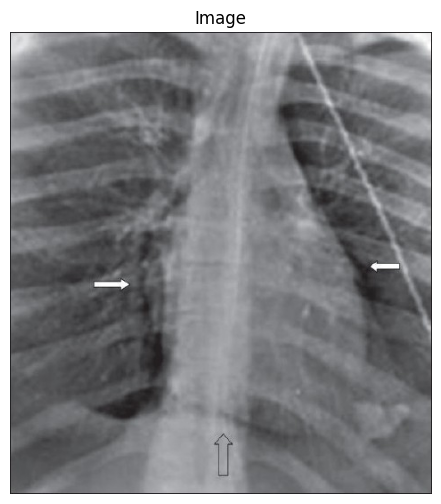

Generated Caption: chest xray show larg opac right hemithorax


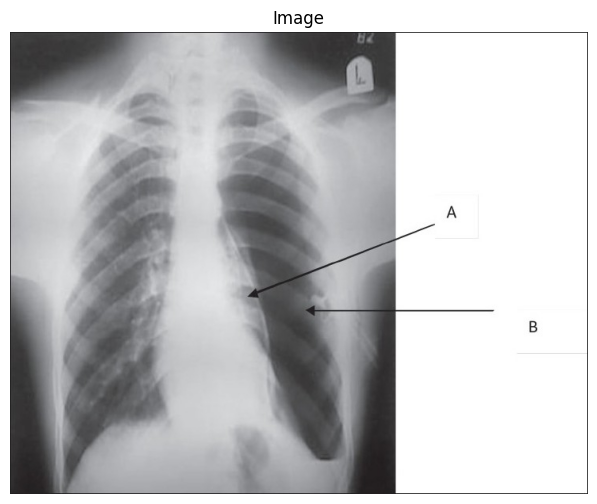

Generated Caption: chest xray show larg opac left hemithorax


In [99]:
import matplotlib.pyplot as plt

# Counter to display only 10 images
count = 0

# Iterate through the test dataset and generate captions for each image
for example in test_dataset:
    if count == 10:
        break  # Exit loop after displaying 10 images
    
    image = example["image"]
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Create a new figure for each image and caption
    fig = plt.figure(figsize=(12, 6))  # Set the size of the figure
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image")  # Title for the image
    plt.show()

    # Display the generated caption
    print("Generated Caption:", generated_caption)
    
    count += 1  # Increment counter after displaying each image
